# Classify images from MNIST using LeNet

## Dataset

Download the [dataset](http://deeplearning.net/data/mnist/mnist.pkl.gz) to your workingspace

In [48]:
import cPickle, gzip

# Load the dataset
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, _ = cPickle.load(f)
f.close()

In [49]:
print train_set[0].shape, train_set[1].shape
print valid_set[0].shape, valid_set[1].shape

(50000, 784) (50000,)
(10000, 784) (10000,)


In [50]:
import numpy as np
train_x = np.reshape(train_set[0], (50000, 1, 28, 28)).astype(np.float32, copy=False)
train_y = np.array(train_set[1]).astype(np.int32, copy=False)
valid_x = np.reshape(valid_set[0], (10000, 1, 28, 28))

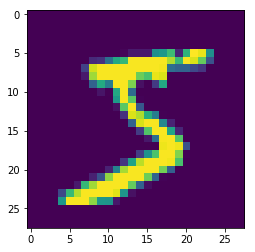

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(train_x[0][0])

## Create the CNN model

TODO: plot the net structure

In [52]:
from singa import net as ffnet
from singa.layer import Conv2D, MaxPooling2D, Dropout, Activation, Flatten, Dense
from singa import optimizer, loss, metric
from singa import layer
layer.engine = 'singacpp'
net = ffnet.FeedForwardNet(loss.SoftmaxCrossEntropy(), metric.Accuracy())
net.add(Conv2D('conv1', 32, 3, 2, input_sample_shape=(1,28,28)))
net.add(Activation('relu1'))
net.add(Conv2D('conv2', 32, 3, 2))
net.add(Activation('relu2'))
net.add(MaxPooling2D('pool', 3, 2))
net.add(Flatten('flat'))
net.add(Dense('dense', 10))


conv1 (32, 14, 14)
relu1 (32, 14, 14)
conv2 (32, 7, 7)
relu2 (32, 7, 7)
pool (32, 4, 4)
flat (512,)
dense (10,)


## Initialize the parameters

* weight matrix - guassian distribution
* bias - 0

In [53]:
for pname, pval in zip(net.param_names(), net.param_values()):
    if len(pval.shape) > 1:
        pval.gaussian(0, 0.1)
    else:
        pval.set_value(0)
    print pname, pval.shape, pval.l1()

conv1_weight (32, 9) 0.0797165706754
conv1_bias (32,) 0.0
conv2_weight (32, 288) 0.0800566524267
conv2_bias (32,) 0.0
dense_weight (512, 10) 0.0792119652033
dense_bias (10,) 0.0


## Set up the optimizer and tensors

In [54]:
from singa import tensor
from singa.proto import core_pb2
from singa import device
from singa import utils
cpu = device.get_default_device()

opt = optimizer.SGD(momentum=0.9, weight_decay=1e-4)
batch_size = 32
num_train_batch = train_x.shape[0] / batch_size

tx = tensor.Tensor((batch_size, 1, 28, 28))
ty = tensor.Tensor((batch_size,), cpu , core_pb2.kInt)

from tqdm import tnrange
idx = np.arange(train_x.shape[0], dtype=np.int32)

## Conduct SGD

1. process the training data multile time, each time is called on epoch; 
2. for each epoch, read the data as mini-batches in random order
3. for each mini-batch, do BP and update the parameters  

In [55]:
for epoch in range(2):
    np.random.shuffle(idx)
    loss, acc = 0.0, 0.0
    
    bar = tnrange(num_train_batch, desc='Epoch %d' % epoch)
    for b in bar:
        x = train_x[idx[b * batch_size: (b + 1) * batch_size]]
        y = train_y[idx[b * batch_size: (b + 1) * batch_size]]
        tx.copy_from_numpy(x)
        ty.copy_from_numpy(y)
        grads, (l, a) = net.train(tx, ty)
        loss += l
        acc += a
        for (s, p, g) in zip(net.param_names(), net.param_values(), grads):
            opt.apply_with_lr(epoch, 0.01, g, p, str(s), b)
        # update progress bar
        bar.set_postfix(train_loss=l, train_accuracy=a)
    print 'Epoch = %d, training loss = %f, training accuracy = %f' % (epoch, loss / num_train_batch, acc / num_train_batch)    



Epoch = 0, training loss = 0.289520, training accuracy = 0.907130

Epoch = 1, training loss = 0.110844, training accuracy = 0.964709


## Save model to disk

In [56]:
net.save('checkpoint')

## Load model from disk

In [57]:
for pval in net.param_values():
    pval.set_value(0)
net.load('checkpoint')

NOTE: If your model was saved using pickle, then set use_pickle=True for loading it
conv2_bias
conv2_weight
dense_weight
conv1_bias
dense_bias
conv1_weight


## Do prediction

In [58]:
from PIL import Image
img = Image.open('static/digit.jpg').convert('L')
img = img.resize((28,28))
img = np.array(img, dtype=np.float32)/255
img = tensor.from_numpy(img)
img.reshape((1,1,28,28))
y=net.predict(img)

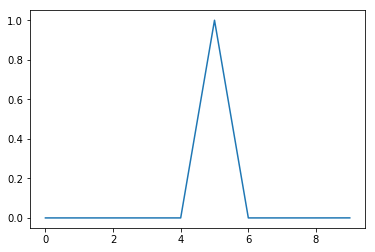

In [59]:
prob=tensor.to_numpy(y)[0]
plt.plot(range(10), prob)

## Debug

Print l1 norm or parameter and layer feature

1. parameter initialization
2. learning rate
3. weight decay


In [66]:
np.random.shuffle(idx)
ffnet.verbose=True
for pname, pval in zip(net.param_names(), net.param_values()):
    if len(pval.shape) > 1:
        pval.gaussian(0, 10)
    else:
        pval.set_value(0)
    print pname, pval.shape, pval.l1()
for b in range(10):
    print "\n\nEpoch %d" % b
    x = train_x[idx[b * batch_size: (b + 1) * batch_size]]
    y = train_y[idx[b * batch_size: (b + 1) * batch_size]]
    tx.copy_from_numpy(x)
    ty.copy_from_numpy(y)
    grads, (l, a) = net.train(tx, ty)
    print '\n loss = %f, params' % l
    for (s, p, g) in zip(net.param_names(), net.param_values(), grads):
        opt.apply_with_lr(epoch, 0.01, g, p, str(s), b)
        print s, p.l1()


conv1_weight (32, 9) 8.34960079193
conv1_bias (32,) 0.0
conv2_weight (32, 288) 7.95598697662
conv2_bias (32,) 0.0
dense_weight (512, 10) 8.03717041016
dense_bias (10,) 0.0


Epoch 0
-->conv1: 4.302002
conv1-->relu1: 2.735491
relu1-->conv2: 786.619568
conv2-->relu2: 367.875519
relu2-->pool: 1118.275635
pool-->flat: 1118.275635
flat-->dense: 252007.656250
-->dense: 0.341626
dense-->flat: 0.341626
flat-->pool: 0.094934
pool-->relu2: 0.054238
relu2-->conv2: 9.602279
conv2-->relu1: 3.184415
relu1-->conv1: 369.496582

 loss = 84.607285, params
conv1_weight 8.74420642853
conv1_bias 8.94533920288
conv2_weight 8.02143383026
conv2_bias 0.136368483305
dense_weight 8.30421638489
dense_bias 0.00292982649989


Epoch 1
-->conv1: 13.531499
conv1-->relu1: 5.077395
relu1-->conv2: 1763.377441
conv2-->relu2: 549.378418
relu2-->pool: 1188.585815
pool-->flat: 1188.585815
flat-->dense: 1785113.750000
-->dense: 0.301339
dense-->flat: 0.301339
flat-->pool: 0.088823
pool-->relu2: 0.039446
relu2-->conv2: 8.60885

In [38]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

In [67]:
np.random.shuffle(idx)
ffnet.verbose=False
net.load('checkpoint')
b=1
x = train_x[idx[b * batch_size: (b + 1) * batch_size]]    
tx.copy_from_numpy(x)

r = net.forward(False, tx, ['relu1', 'relu2'])


    

NOTE: If your model was saved using pickle, then set use_pickle=True for loading it
conv2_bias
conv2_weight
dense_weight
conv1_bias
dense_bias
conv1_weight


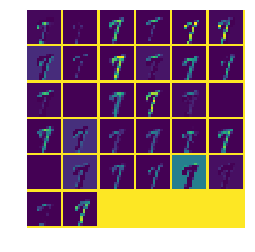

In [46]:
r1 = tensor.to_numpy(r['relu1'])[0]
vis_square(r1)

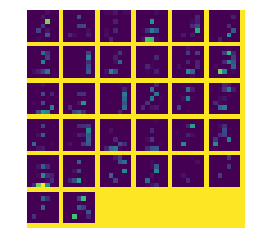

In [68]:
r2 = tensor.to_numpy(r['relu2'])[0]
vis_square(r2)

In [73]:
p=net.param_values()[2]
print p.shape

(32, 288)


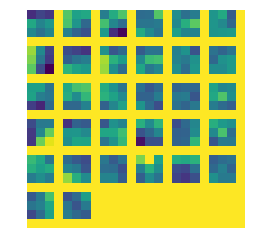

In [72]:
vis_square(tensor.to_numpy(p).reshape(32, 3,3))